In [785]:
import numpy as np
from collections import namedtuple
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.stats import norm
from copy import *
from numpy.matlib import * 
from scipy.optimize import *


# Translate functions in polyline.m

In [929]:
def polyline(x, y=None, label=None):
    """This function converts the """
    # create output container
    obj = np.empty((2,len(x)))
    
    # condition output on the number on function inputs 
    if x is not None:
        x = np.array(x).flatten()
        obj[0,:] = x
    if y is not None:
        y = np.array(y).flatten()
        obj[1,:] = y
        
    return obj


def sort_polyline(obj):
    if not isinstance(obj, list):
        obj = [obj]
    result = copy.deepcopy(obj)
    for k in range(len(obj)):
        inds = result[k][0].argsort()
        
        result[k][0] = result[k][0][inds] 
        if len(result[k] > 1):
            result[k][1] = result[k][1][inds] 
    if len(result) == 1:
        result = result[0]
    
    return result


def get_len(obj):
    "This function returns the length of the polyline objects"
    if not isinstance(obj, list):
        obj = [obj]
        
    container = []
    # if obj only includes one polyline nametuple
    for element in range(len(obj)):
        container += [np.prod(obj[element][0,:].shape)]
        assert np.prod(obj[element][0,:].shape) == np.prod(obj[element][1,:].shape), "Polyline with mismatch of the number of points: x has {} while y has {}".format(np.prod(obj[element][0,:].shape), np.prod(obj[element][1,:].shape))
            
    
    return np.array(container)

def interpolate(xx, obj, one=False):    
    if not one:
        interpolation = InterpolatedUnivariateSpline(obj[0], obj[1], k=1)
        container = interpolation(xx)
        extrapolate = [True if (i>max(obj[0])) |(i<min(obj[0])) else False for i in xx]
    else:
        container = []
        extrapolate = []
        
        for poly  in obj:
            interpolation = InterpolatedUnivariateSpline(poly[0], poly[1], k=1)
            container += [interpolation(xx)]
            extrapolate += [np.array([True if (i>max(poly[0])) |(i<min(poly[0])) else False for i in xx])]
    return container, extrapolate


def inset(obj, x, y, j= 0):
    
    if not isinstance(obj, list):
        obj = [obj]
        
    result = deepcopy(obj)

    if np.prod(x.shape) >1:
        mx = np.prod(x.shape)
        my = np.prod(y.shape)
        for k in range(len(obj)):
            if j == 0:
                result[k][0,:] = np.append(result[k][0,:], result[k][0,:])
                result[k][1,:] = np.append(result[k][1,:], result[k][1,:])
            else:
                result[k][0,:] = np.append(result[k][0,:][:j],np.append(x, result[k][0,:][j:]))
                result[k][1,:] = np.append(result[k][1,:][:j],np.append(y, result[k][1,:][j:]))
                
    elif (np.prod(x.shape) ==1):

        for k in range(len(obj)):
            if (j ==0) | (j > np.prod(result[k][0,:].shape)):
                result[k][0,:] = np.append(result[k][0,:], x)
                result[k][1,:] = np.append(result[k][1,:], y)
            else:
                result[k][0,:] = np.append(result[k][0,:][:j], np.append(x, result[k][0,:][j:]))
                result[k][1,:] = np.append(result[k][1,:][:j], np.append(x, result[k][1,:][j:]))
                
    if len(result) == 1:
        result = result[0]
    else:
        pass
        
                
    return result


def thinout(obj, indx):
    if not isinstance(obj, list):
        obj = [obj]
    
    result = copy.deepcopy(obj)
    
    for k in range(len(obj)):
        index = [np.where(obj[k][0,:] == i)[0][0] for i in indx] 
        result = np.empty((len(obj),2,len(np.delete(obj[k][0,:], index))))
        result[k][0,:] = np.delete(obj[k][0,:], index)
        
        result[k][1,:] = np.delete(obj[k][1,:], index)

    return result

 
def diff(obj, pl2, significance=5):
    
    if not isinstance(obj, list):
        obj = [obj]
    result = copy.deepcopy(obj)
    
    x1 = np.round(pl2[0]['x'] * (10 ** significance)) * (10 ** (-significance))
    y1 = np.round(pl2[0]['y'] * (10 ** significance)) * (10 ** (-significance))
    
    for k in range(len(result)):
        x=np.round(obj[k]['x']*(10**significance)) * (10**(-significance))
        y=np.round(obj[k]['y']*(10**significance)) * (10**(-significance))
        index = [np.where(x)[0][0] for i in x1 ] 
        index = [np.where(y)[0][0] for i in x1 ] 

      
    return result

def grow(obj, ind2, front=False):
    if not isinstance(obj, list):
        obj = [obj]
    if not isinstance(ind2, list):
        ind2 = [ind2]

    result = []  
    for k1 in range(len(obj)):
        result += [[]]
        for k2 in range(len(ind2)):

            if front:
                x_new = np.append(ind2[k2][0,:], obj[k1][0,:])
                y_new =  np.append(ind2[k2][1,:], obj[k1][1,:])
                result[k1] += [polyline(x_new, y_new)]

            else:
                x_new = np.append(obj[k1][0,:], ind2[k2][0,:])
                y_new =  np.append(obj[k1][1,:], ind2[k2][1,:])
                result[k1] += [polyline(x_new, y_new)]
    return result
            

def aux_function(x, obj1, obj2):
    x = [x]
    value, extr = np.subtract(interpolate(x,obj1), interpolate(x, obj2))
    return value
    

    
def upper_envelope(obj, fullinterval=False, intersection=False):
    
    # Assert if input of polyline objects is not an array (length==1)
    assert (len(obj) != 1), 'Upper envelope is meant for an array of polylines'
    length = []
    
    # copy original input
    aux_object = deepcopy(obj)
    
    # check length of polyline entries and drop polylines with x-length == 0
    for k1 in range(len(obj)):
        length += [(len(obj[k1][0]), len(obj[k1][1]))]
        aux_object[k1] = [i for i in aux_object[k1] if len(i) != 0]
    
    # Get all unique values of x
    xx = np.array([])
    for k1 in range(len(aux_object)):
           xx = np.append(xx, aux_object[k1][0].astype(list))
    xx = np.unique(xx)
    xx = np.array([i for i in xx])
    # set up containers
    interpolated = np.empty((len(obj), len(xx))) 
    extrapolated = np.empty((len(obj), len(xx)))
    
    # interpolate for each unique value of x
    for counter in range(len(obj)):
        inter, extra = interpolate(xx, obj[counter])
        interpolated[counter, :] = inter
        extrapolated[counter, :] = extra
    extrapolated = extrapolated.astype(bool)
    
    if not fullinterval:
        mask = np.sum(extrapolated, axis=0) > 0
        container = np.empty((interpolated.shape[0], int(mask.sum())))
        for i in range(interpolated.shape[0]):
            container[i,:] = np.extract(mask, interpolated[i,:])
        interpolated = container
        xx = xx[mask]
        n = sum(~mask)
    else:
        interpolated[extrapolated] = -np.inf
        n = len(xx)
        
    # create upper envelope
    maxinterpolated = repmat(interpolated.max(axis=0), m=interpolated.shape[0], n=1)
    top=interpolated==maxinterpolated 
    result_upper = polyline(xx, maxinterpolated[1,:])
    result_inter = np.empty((2,0))

    Test = True
    if Test is True:
        k0 = np.where(top[:,0]==True)[0][0]
        for i in range(1, n):
            k1 = np.where(top[:,i]==True)[0][0]
            if k1 != k0:
                ln1 = k0
                ln2 = k1
                xx1 = xx[i - 1]
                xx2 = xx[i]
                y1, extr1 = interpolate([xx1, xx2], aux_object[ln1])
                y2, extr2 = interpolate([xx1, xx2], aux_object[ln2])
                if all(~np.stack([extr1, extr2])) & all(abs(y1-y2)>0):
                    xx3 = brenth(aux_function, xx1, xx2, args=(aux_object[ln1], aux_object[ln2]))
                    xx3f, _ = interpolate([xx3], aux_object[ln1])
                    # set up containers
                    interpolated2 = np.empty((len(obj), 1)) 
                    extrapolated2 = np.empty((len(obj), 1))

                    # interpolate for each unique value of x
                    for counter in range(len(obj)):
                        inter2, extra2 = interpolate([xx3], obj[counter])
                        interpolated2[counter] = inter2
                        extrapolated2[counter] = extra2

                    extrapolated2 = extrapolated2.astype(bool)
                    interpolated2[extrapolated2] = -np.inf
                    maxinterpolated2 = repmat(interpolated2.max(), m=len(obj), n=1)
                    ln3=np.where(interpolated2==maxinterpolated2)[0][0]
                    if (ln3==ln1) | (ln3==ln2):
                        #there are no other functions above!
                        #add the intersection point
                        if intersection:
                            print(np.append(result_inter[0], [xx3]))
                            result_inter[0] = np.append(result_inter[0], [xx3])
                            print(result_inter[0])
                            result_inter[1] = np.append(result_inter[1], [xx3f])
                            print(result_inter)
                        if ln2==k1:
                            break
                        else:
                            ln1=ln2
                            xx1=xx3
                            ln2=k1
                            xx2=xx[i]
                    else:
                        ln2=ln3
                        xx2=xx3
            k0=deepcopy(k1)
            
    return result_upper, result_inter       

In [930]:
a= np.arange(-10,40, 0.1)
len(a)


500

[6.]
[]
[]


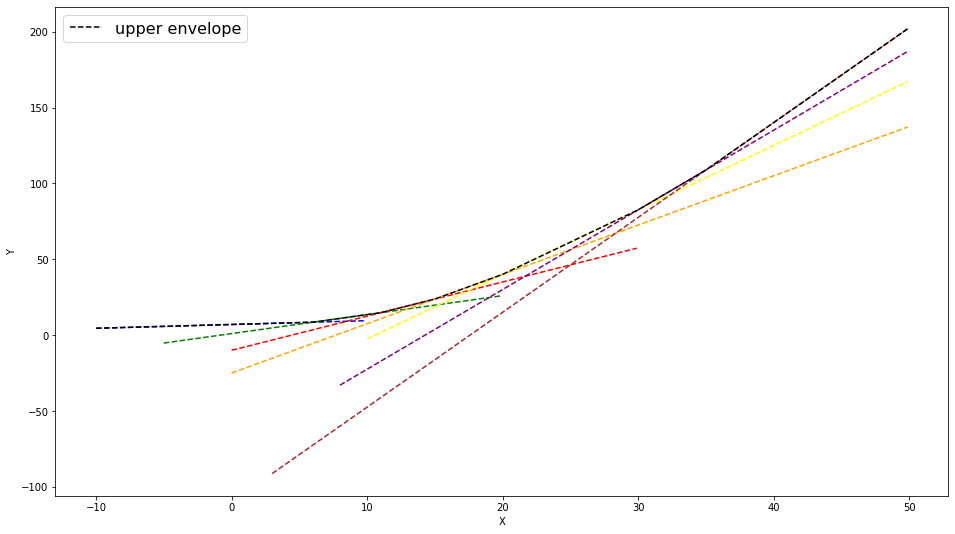

In [931]:
import matplotlib.pyplot as plt

%matplotlib inline

a= np.arange(-10,50, 0.1)

# create some example polyline objects
y1 = 0.25*a[:200] +7
y2= 1.25 * a[50:300] + 1
y3 = 2.25 * a[100:400] - 10
y4 = 3.25 * a[100:] - 25
y5 = 4.25 * a[200:] - 45
y6 = 5.25 * a[180:] - 75
y7 = 6.25 * a[130:] - 110


# plot example polyline objects


poly1 = polyline(a[:200], y1)
poly2 = polyline(a[50:300], y2)
poly3 = polyline(a[100:400], y3)
poly4 = polyline(a[100:], y4)
poly5 = polyline(a[200:], y5)
poly6 = polyline(a[180:], y6)
poly7 = polyline(a[130:], y7)

object_ = [poly1, poly2, poly4, poly3, poly5, poly6, poly7]

# calculate upper envelope
x, b = upper_envelope(object_,fullinterval=True, intersection=True)

# plot upper envelope and polylines
ax = plt.figure(figsize=[16,9]).add_subplot(111)
ax.set_ylabel("Y")
ax.set_xlabel("X")
plt.plot(a[:200], y1, linestyle='--', color='blue')
plt.plot(a[50:300], y2, linestyle='--', color='green')
plt.plot( a[100:400], y3, linestyle='--', color='red')
plt.plot( a[100:], y4, linestyle='--', color='orange')
plt.plot( a[200:], y5, linestyle='--', color='yellow')
plt.plot( a[180:], y6, linestyle='--', color='purple')
plt.plot( a[130:], y7, linestyle='--', color='brown')

plt.plot(x[0], x[1], linestyle='--', color='black', label='upper envelope')
plt.legend(prop={"size": 16})
plt.show()


In [925]:
b

array([], shape=(2, 0), dtype=float64)

In [911]:
x[1]

array([], dtype=float64)